# TreeSHAP-IQ for LightGBM

This tutorial demonstrates how to use the `TreeExplainer` class of `shapiq` to explain a LightGBM model.

### Model-specific Shapley interaction values

Unlike other explanation methods based on model-agnostic approximation algorithms such as [SHAP-IQ](https://openreview.net/forum?id=eX73tYK3RV), [SVARM-IQ](https://proceedings.mlr.press/v238/kolpaczki24a.html), or [KernelSHAP-IQ](https://proceedings.mlr.press/v235/fumagalli24a.html), the [TreeSHAP-IQ](https://ojs.aaai.org/index.php/AAAI/article/view/29352) explainer is a model-specific method that works much faster for tree-based models.

**Model-Agnostic.** The model-agnostic explainers/approximators are limited by the number of features.
Computing Shapley values and interactions is a combinatorial problem with exponential complexity in the number of features, i.e. with one additional feature, the number of possible interactions doubles.
Hence, model-agnostic methods become infeasible for growing numbers of features.

**Model-Specific.** However, if we know something about the structure of the underlying cooperative game (model), we can exploit this knowledge to compute Shapley values and interactions much more efficiently and potentially without depending on the number of features.
For example, if we know that the model is a tree-based model, we know that not all features can interact with each other, because at each split node, data is partitioned based on a single feature and data can only follow one path (left or right).
There is a growing body of research on model-specific Shapley value computation, especially for tree-based models.

**Tree-Specific.** For Shapley value computation, the [TreeSHAP](https://doi.org/10.1038/s42256-019-0138-9) algorithm and the subsequent [Linear TreeSHAP](https://openreview.net/forum?id=OzbkiUo24g) algorithm exist.
Linear TreeSHAP computes Shapley values for tree-based models in linear time complexity in the number of features.
For Shapley interaction values, the [TreeSHAP-IQ](https://ojs.aaai.org/index.php/AAAI/article/view/29352) algorithm extends Linear TreeSHAP to compute Shapley interaction values for tree-based models in linear time complexity in the number of features.

### Import Modules

In [1]:
import lightgbm
from sklearn.model_selection import train_test_split

import shapiq

{"shapiq": shapiq.__version__, "lightgbm": lightgbm.__version__}

{'shapiq': '1.2.3.9000', 'lightgbm': '4.6.0'}

### Load Data
We use the `load_bike_sharing` function to load the bike sharing dataset.
The bike sharing dataset contains 12 features and 1 target variable.
The bike-sharing dataset can be downloaded from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset).

In [2]:
X, y = shapiq.load_bike_sharing()
X_train, X_test, y_train, y_test = train_test_split(
    X.values,
    y.values,
    test_size=0.25,
    random_state=42,
)
n_features = X_train.shape[1]
X_train.shape, X_test.shape

((13034, 12), (4345, 12))

### Train a Tree-based Model
Train a LightGBM model on the bike sharing dataset.
We use the `LGBMRegressor` class from the `lightgbm` package.

In [3]:
model = lightgbm.LGBMRegressor(n_estimators=100, max_depth=n_features, random_state=42, verbose=-1)
model.fit(X_train, y_train)
print(f"Train R2: {model.score(X_train, y_train):.4f}")
print(f"Test  R2: {model.score(X_test, y_test):.4f}")

Train R2: 0.9599
Test  R2: 0.9478


/Users/max/PycharmProjects/shapiq/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/max/PycharmProjects/shapiq/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


### Model-Specific Explainer for Tree-Based Models

We use `shapiq.TreeExplainer` to explain a tree-ensemble model for tabular data. 
The `TreeExplainer` is an implementation of the [TreeSHAP-IQ](https://ojs.aaai.org/index.php/AAAI/article/view/29352) algorithm.

It has the following basic parameters:
- `model`: The model to be explained.
- `max_order`: The maximum interaction order to be computed. An interaction order of 1 corresponds to the Shapley value.  Any value higher than 1 computes the Shapley interaction values up to that order. Defaults to 2.
- `min_order`: The minimum interaction order to be computed. Defaults to 1.
- `index`: The interaction index to be computed. It can be one of: "k-SII" (default), "SII", "STII", "FSII", or "BII". Note that all indices apart from "BII" will reduce to the "SV" (Shapley value) for order 1.

**Note:** If you set `max_order=1` or `index="SV"`, the explainer will compute the Shapley values (SV) only.
Then, the algorithm will be equivalent to the [Linear TreeSHAP](https://openreview.net/forum?id=OzbkiUo24g) algorithm.

In [4]:
explainer = shapiq.TreeExplainer(model=model, index="k-SII", min_order=1, max_order=3)

/Users/max/PycharmProjects/shapiq/shapiq/explainer/tree/conversion/lightgbm.py:44: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  booster_df["split_feature"].replace(convert_feature_str_to_int).infer_objects(copy=False)
/Users/max/PycharmProjects/shapiq/shapiq/explainer/tree/conversion/lightgbm.py:75: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .replace(convert_node_str_to_int)
/Users/max/PycharmProjects/shapiq/shapiq/explainer/tree/conversion/lightgbm.py:81: FutureWarning: Downcasting behavior in `replace` is deprecated and will

Next, select an instance to be explained.

In [5]:
x = X_test[1234]

Call the `explain()` interface.

In [6]:
interaction_values = explainer.explain(x)
print(interaction_values)

InteractionValues(
    index=k-SII, max_order=3, min_order=0, estimated=False, estimation_budget=None,
    n_players=12, baseline_value=190.379622526228,
    Top 10 interactions:
        (): 190.379622526228
        (np.int64(0),): 35.08515951088173
        (np.int64(1), np.int64(5)): 14.984490827501197
        (np.int64(0), np.int64(1)): 14.0334453650743
        (np.int64(0), np.int64(8)): -13.612044956259036
        (np.int64(2),): -15.38758485486277
        (np.int64(6),): -21.973797366562582
        (np.int64(0), np.int64(9)): -32.874036577563004
        (np.int64(5),): -42.991609226571185
        (np.int64(1),): -56.72710843542334
)


An output is stored in the `shapiq.InteractionValues` object. Its main attribute is `dict_values` storing Shapley interaction values as a dictionary.

One can retrieve only 1-order values with `get_n_order(1)` (object) and `get_n_order_values(1)` (values themselves).

In [7]:
interaction_values.get_n_order(1).dict_values

{(np.int64(0),): 35.08515951088173,
 (np.int64(1),): -56.72710843542334,
 (np.int64(5),): -42.991609226571185,
 (np.int64(9),): -4.207060851031494,
 (np.int64(10),): -10.861061944301126,
 (np.int64(11),): -2.472089266311493,
 (np.int64(2),): -15.38758485486277,
 (np.int64(3),): 5.3718572439156915,
 (np.int64(6),): -21.973797366562582,
 (np.int64(8),): -5.93463739128977,
 (np.int64(7),): 0.2544493980293309,
 (np.int64(4),): 0.5157679457472459}

In [8]:
interaction_values.get_n_order_values(2).shape

(12, 12)

### Visualization of Shapley Interactions

`shapiq` includes a variaty of visualization functions to help you understand the Shapley interaction values.
In the following, we demonstrate how to use the following functions:

- [network_plot()](https://shapiq.readthedocs.io/en/latest/api/shapiq.plot.html#shapiq.plot.network_plot)
- [stacked_bar_plot()](https://shapiq.readthedocs.io/en/latest/api/shapiq.plot.html#shapiq.plot.stacked_bar_plot)
- [force_plot()](https://shapiq.readthedocs.io/en/latest/api/shapiq.plot.html#shapiq.plot.force_plot)
- and [bar_plot()](https://shapiq.readthedocs.io/en/latest/api/shapiq.plot.html#shapiq.plot.bar_plot) for global feature (interaction) importance.

For details of their parameters, we refer to the [API reference](https://shapiq.readthedocs.io/en/latest/api/shapiq.plot.html).

#### Network Plot for Local Feature Attribution
The network plot easily visualizes the Shapley interaction values for a single instance.

(<Figure size 600x600 with 1 Axes>, <Axes: >)

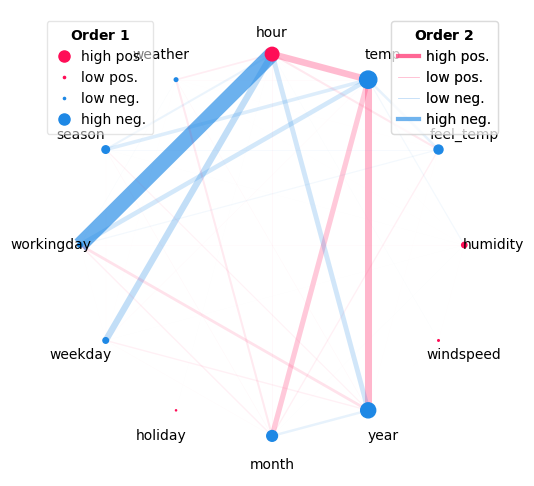

In [9]:
shapiq.network_plot(
    first_order_values=interaction_values.get_n_order_values(1),
    second_order_values=interaction_values.get_n_order_values(2),
    feature_names=X.columns,
)

#### Stacked Bar Plot for Visualizing Amount of Interaction
The stacked bar plot can be used to see how much interaction each feature has.
It can be plotted for single features or interactions. 

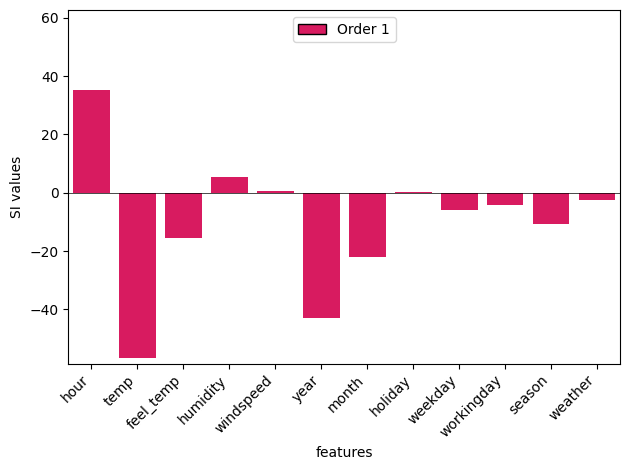

In [10]:
# single features (1-order)
_ = shapiq.stacked_bar_plot(
    interaction_values=interaction_values.get_n_order(1),
    feature_names=X.columns,
)

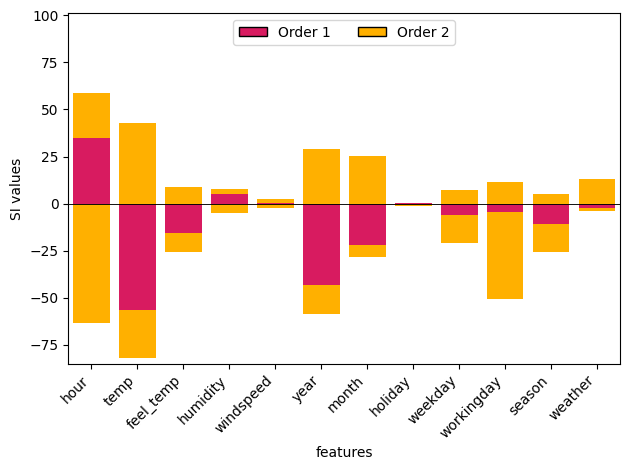

In [11]:
# run this for interactions (2-order)
_ = shapiq.stacked_bar_plot(
    interaction_values=interaction_values.get_n_order(2, min_order=1),
    feature_names=X.columns,
)

After installing the `shap` Python package.

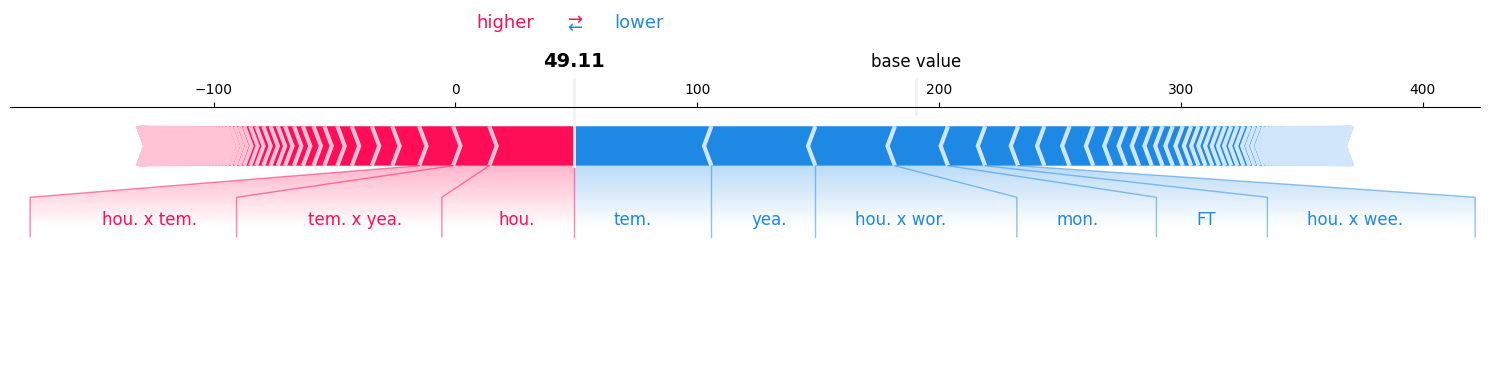

In [12]:
interaction_values.plot_force(feature_names=X.columns, contribution_threshold=0.03)

### Global Feature (Interaction) Importance

We can compute interaction values for a set of samples and visualize their global aggregation.

In [13]:
list_of_interaction_values = explainer.explain_X(X_test[:50,])
len(list_of_interaction_values) == 50

True

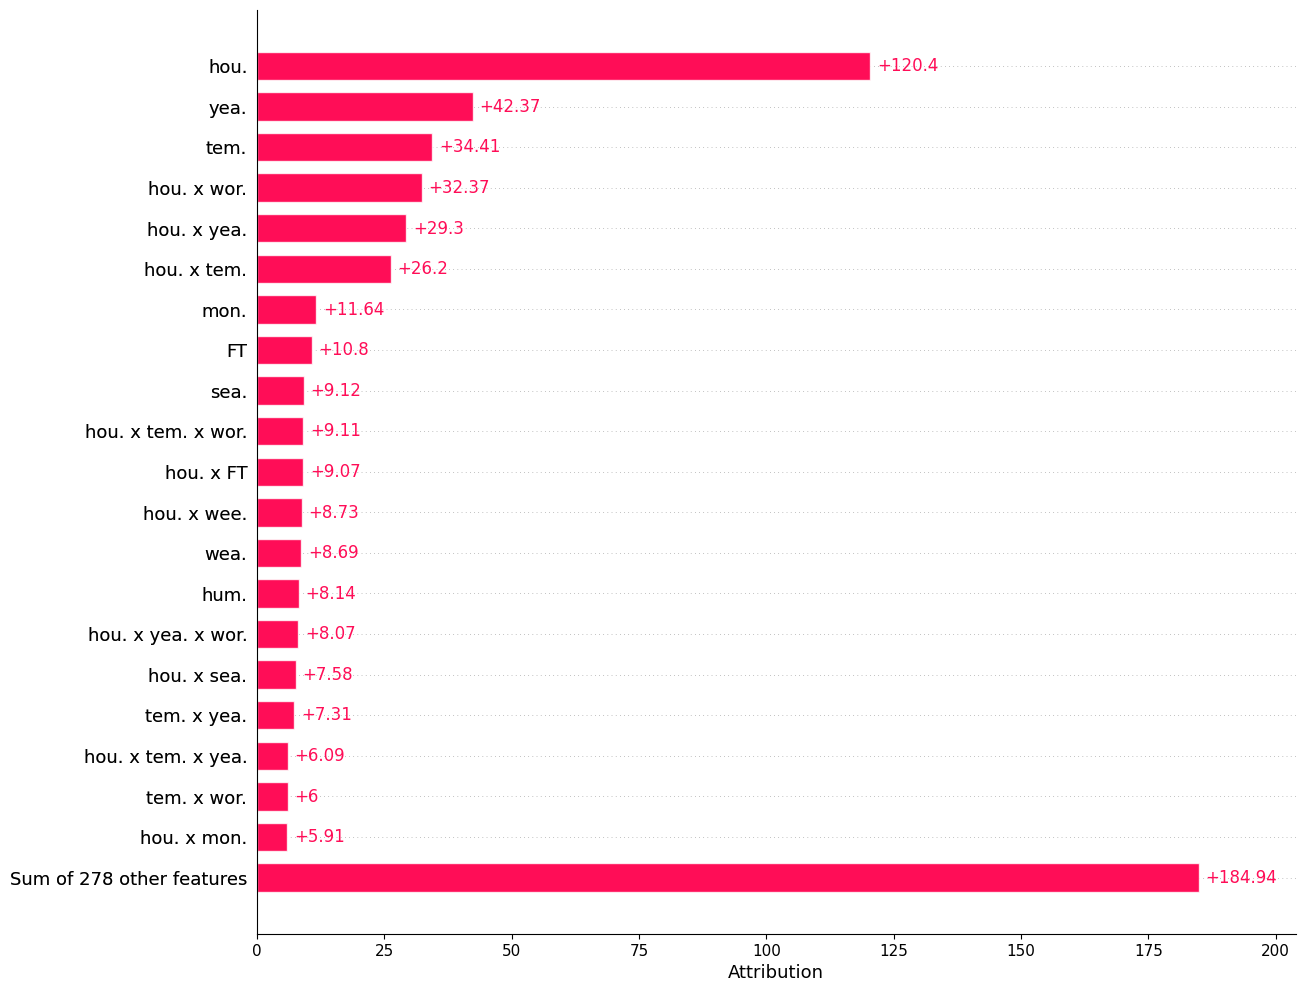

In [14]:
shapiq.plot.bar_plot(list_of_interaction_values, feature_names=X.columns, max_display=20, show=True)

### References
Fumagalli et al. (2023). SHAP-IQ: Unified Approximation of any-order Shapley Interactions In. NeurIPS'2023 https://openreview.net/forum?id=eX73tYK3RV

Fumagalli et al. (2024). KernelSHAP-IQ: Weighted Least Square Optimization for Shapley Interactions In. ICML'2024 https://proceedings.mlr.press/v235/fumagalli24a.html

Lundberg et al. (2020). From local Explanations to Global Understanding with Explainable AI for Trees. In Nature Machine Intelligence, 2(1), 56-67. https://doi.org/10.1038/s42256-019-0138-9

Muschalik et al. (2024). Beyond TreeSHAP: Efficient Computation of Any-Order Shapley Interactions for Tree Ensembles. In AAAI'2024. https://ojs.aaai.org/index.php/AAAI/article/view/29352

Kolpaczki et al. (2024)  SVARM-IQ: Efficient Approximation of Any-Order Shapley Interactions through Stratification. In AISTATS'2024. https://proceedings.mlr.press/v238/kolpaczki24a.html

Yu et al. (2022). Linear TreeSHAP. In NeurIPS'2022. https://openreview.net/forum?id=OzbkiUo24g